In [1]:
pwd

'/scratch/yl7692'

# 2.Preprocess the Datasets

In [2]:
pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt

## 1) Visualize the MRI images 

## 2) Define function to process 2 raters' groundtruth  

## 3) Make the custom dataset

In [3]:
import glob

In [4]:
base_path = '/scratch/yl7692/training/'
second_path_list = ['training01/','training02/','training03/','training04/','training05/']
mri_list = []
mask1_list = []
mask2_list = []
for i in range(5):
    timepoint1_path = os.path.join(base_path, second_path_list[i], 'preprocessed/*_01_*.nii')
    timepoint2_path = os.path.join(base_path, second_path_list[i], 'preprocessed/*_02_*.nii')
    timepoint3_path = os.path.join(base_path, second_path_list[i], 'preprocessed/*_03_*.nii')
    timepoint4_path = os.path.join(base_path, second_path_list[i], 'preprocessed/*_04_*.nii')
    if i==2:
        timepoint5_path = os.path.join(base_path, second_path_list[i], 'preprocessed/*_05_*.nii')
    mask1_path = os.path.join(base_path, second_path_list[i], 'masks/*1.nii')
    mask2_path = os.path.join(base_path, second_path_list[i], 'masks/*2.nii')
    timepoint1_list = sorted(glob.glob(timepoint1_path))
    timepoint2_list = sorted(glob.glob(timepoint2_path))
    timepoint3_list = sorted(glob.glob(timepoint3_path))
    timepoint4_list = sorted(glob.glob(timepoint4_path))
    if i==2:
        timepoint5_list = sorted(glob.glob(timepoint5_path))
    mri_list.append(timepoint1_list)
    mri_list.append(timepoint2_list)
    mri_list.append(timepoint3_list)
    mri_list.append(timepoint4_list)
    if i==2:
        mri_list.append(timepoint5_list)
    mask1_list = mask1_list + sorted(glob.glob(mask1_path))
    mask2_list = mask2_list + sorted(glob.glob(mask2_path))
print('Data Collected:', len(mri_list))
print('Mask1 Collected:', len(mask1_list))
print('Mask2 Collected:', len(mask2_list))

Data Collected: 21
Mask1 Collected: 21
Mask2 Collected: 21


In [5]:
mri_list

[['/scratch/yl7692/training/training01/preprocessed/training01_01_flair_pp.nii',
  '/scratch/yl7692/training/training01/preprocessed/training01_01_mprage_pp.nii',
  '/scratch/yl7692/training/training01/preprocessed/training01_01_pd_pp.nii',
  '/scratch/yl7692/training/training01/preprocessed/training01_01_t2_pp.nii'],
 ['/scratch/yl7692/training/training01/preprocessed/training01_02_flair_pp.nii',
  '/scratch/yl7692/training/training01/preprocessed/training01_02_mprage_pp.nii',
  '/scratch/yl7692/training/training01/preprocessed/training01_02_pd_pp.nii',
  '/scratch/yl7692/training/training01/preprocessed/training01_02_t2_pp.nii'],
 ['/scratch/yl7692/training/training01/preprocessed/training01_03_flair_pp.nii',
  '/scratch/yl7692/training/training01/preprocessed/training01_03_mprage_pp.nii',
  '/scratch/yl7692/training/training01/preprocessed/training01_03_pd_pp.nii',
  '/scratch/yl7692/training/training01/preprocessed/training01_03_t2_pp.nii'],
 ['/scratch/yl7692/training/training01/p

In [6]:
train_img_list = mri_list[0:17]
val_img_list = mri_list[17:21]
train_label1_list = mask1_list[0:17]
train_label2_list = mask2_list[0:17]
val_label1_list = mask1_list[17:21]
val_label2_list = mask2_list[17:21]
print ("Training set size: {}". format(len(train_img_list)))
print ("Training label1 size: {}". format(len(train_label1_list)))
print ("Training label2 size: {}". format(len(train_label2_list)))
print ("Validation set size: {}". format(len(val_img_list)))
print ("Validation label1 size: {}". format(len(val_label1_list)))
print ("Validation label2 size: {}". format(len(val_label2_list)))

Training set size: 17
Training label1 size: 17
Training label2 size: 17
Validation set size: 4
Validation label1 size: 4
Validation label2 size: 4


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from tqdm import tqdm

class MRIDataset(Dataset):
    def __init__(self, img_path_list, label1_path_list, label2_path_list , IF_TRAIN= False):
        self.mri_path_list = img_path_list
        self.label1_path_list = label1_path_list
        self.label2_path_list = label2_path_list
        self.IF_TRAIN = IF_TRAIN
        #self.transform=transforms.Compose([transforms.Normalize((0.5,),(0.5,))])
        self.mri_list, self.mask1_list, self.mask2_list = self.preprocess() 

    def __len__(self):
        return len(self.mri_list)

    def preprocess(self):
        mri_list, mask1_list, mask2_list, mask_and_list, mask_or_list, mask_rnd_list = [], [], [], [], [], []
        for idx in tqdm(range(len(self.mri_path_list))):
            mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
            mri_t2f = (mri_t2f-mri_t2f.min())/(mri_t2f.max()-mri_t2f.min())
            
            mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
            mri_t1w = (mri_t1w-mri_t1w.min())/(mri_t1w.max()-mri_t1w.min())
            
            mri_pd = torch.Tensor(nib.load(self.mri_path_list[idx][2]).get_data())
            mri_pd = (mri_pd-mri_pd.min())/(mri_pd.max()-mri_pd.min())
            
            mri_t2w = torch.Tensor(nib.load(self.mri_path_list[idx][3]).get_data())
            mri_t2w = (mri_t2w-mri_t2w.min())/(mri_t2w.max()-mri_t2w.min())
            
            mri = torch.cat((mri_t1w.unsqueeze(0),mri_t2w.unsqueeze(0),mri_pd.unsqueeze(0),mri_t2f.unsqueeze(0)),axis=0)
            
            mask1 = torch.Tensor(nib.load(self.label1_path_list[idx]).get_data())
            mask2 = torch.Tensor(nib.load(self.label2_path_list[idx]).get_data())
            
            mri_list.append(mri)
            mask1_list.append(mask1)
            mask2_list.append(mask2)
        return mri_list, mask1_list, mask2_list

    def __getitem__ (self,idx):
        img = self.mri_list[idx]
        mask1 = self.mask1_list[idx]
        mask2 = self.mask2_list[idx]
            
        label1 = torch.Tensor(mask1)
        label2 = torch.Tensor(mask2)

        return img, label1, label2

In [8]:
train_dataset = MRIDataset(train_img_list, train_label1_list, train_label2_list, IF_TRAIN= True)
val_dataset = MRIDataset(val_img_list, val_label1_list, val_label2_list, IF_TRAIN= False)

  0%|          | 0/17 [00:00<?, ?it/s]<ipython-input-7-3e9913983266>:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
<ipython-input-7-3e9913983266>:27: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
<ipython-input-7-3e9913983266>:30: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more pred

In [9]:
NUM_EPOCH = 100
BATCH_SIZE = 4
LR = 0.0005
SAVE_PATH = "/scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/"

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)

# 3.Build the Network

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x
    
class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x
    
    
class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

    
class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=4, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 8
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        #filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        self.Maxpool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv3d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)
        #print("e1", e1.shape)
        e2 = self.Maxpool1((e1))
        e2 = self.Conv2(e2)
        #print("e2", e2.shape)
        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)
        #print("e3", e3.shape)
        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)
        #print("e4", e4.shape)
        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)
        #print("e5", e5.shape)
        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        e4 = e4[:,:,:,0:-1,:]
        #print("e4 new", e4.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        e3 = e3[:,:,0:-1,0:-2,0:-1]
        #print("e3 new", e3.shape)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        e2 = e2[:,:,0:-2,0:-4,0:-2]
        #print("e2 new", e2.shape)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        #print("d2", d2.shape)
        padding = nn.ConstantPad3d(((2, 3, 4, 5, 2, 3)), 0)
        d2 = padding(d2)
        #print("d2 new", d2.shape)
        #print("e1", e1.shape)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)


      #  out = self.active(out)

        return out

In [14]:
net = AttU_Net(4,1).to(device)
a = torch.zeros(1, 4, 181, 217, 181).to(device)
b = net(a)
print(a.shape)
print(b.shape)

torch.Size([1, 4, 181, 217, 181])
torch.Size([1, 1, 181, 217, 181])


# 4.Dice Loss

In [13]:
# define dice coefficient
def dice_coeff(pred, target):
    smooth = 1
    # First let's flatten the matrix to [Batch Size, -1]
    # The flatten operation does not afftect the computation of the above equation
    num = pred.size(0)
    m1 = pred. view(num, -1). float() # Flatten
    m2 = target. view(num, -1). float() # Flatten
    # Then we compute the intersection and the sum of cardinality
    intersection = 2*torch.sum(m1*m2,dim= 1) + smooth
    cardinality = torch.sum(m1**2,dim= 1) + torch.sum(m2**2,dim= 1) + smooth
    # Followed by Dice
    dice = intersection/cardinality
    return dice.mean()
# define SoftDICE loss as 1 - SoftDICE
class SoftDICELoss(nn. Module):
    def __init__(self, smooth = 1):
        super(SoftDICELoss, self). __init__()
        self. smooth = smooth
    def forward(self, pred, target):
        loss = 1 - dice_coeff(pred, target)
        return loss.mean()

# 5.Training

In [14]:
def train_epoch(net, data_loader, optimizer, criterion, epoch):

    net = net.train()
    optimizer.zero_grad()
    loss_stat = []
    loss_stat_mask1 = []
    loss_stat_mask2 = []
    for i, img_mask in enumerate(data_loader):
        img, mask1,mask2 = img_mask

        img = img.to(device)
        mask1 = mask1.to(device)
        mask2 = mask2.to(device)

        pred = net(img)

        loss_mask1 = criterion(pred, mask1)
        loss_mask2 = criterion(pred, mask2)
        loss = (loss_mask1 + loss_mask2)/2.
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_stat += [loss.item()]*img.shape[0]
        loss_stat_mask1 += [loss_mask1.item()]*img.shape[0]
        loss_stat_mask2 += [loss_mask2.item()]*img.shape[0]
        
    print ("Epoch {}: [{}/{}] Loss: {:.3f} Loss_mask1: {:.3f} Loss_mask2: {:.3f}". 
           format(epoch, len(data_loader)-1, len(data_loader)-1,np.mean(loss_stat),np.mean(loss_stat_mask1),np.mean(loss_stat_mask2)))
    return np.mean(loss_stat),np.mean(loss_stat_mask1),np.mean(loss_stat_mask2)

In [15]:
def eval_epoch(net, data_loader, metric, criterion):
    # set model in eval mode to avoid updating BN layer
    net = net.eval()
    
    metric_stat = []
    metric_stat_mask1 = []
    metric_stat_mask2 = []
    
    val_loss_stat = []
    val_stat_mask1 = []
    val_stat_mask2 = []
    for i, img_mask in enumerate(data_loader):
        img, mask1,mask2 = img_mask
        # send data to device
        img = img.to(device)
        mask1 = mask1.to(device)
        mask2 = mask2.to(device)
        # feed data to the model. No need to compute grad.
        with torch.no_grad():
            pred = net(img)
            val_loss_mask1 = criterion(pred, mask1)
            val_loss_mask2 = criterion(pred, mask2)
            val_loss = (val_loss_mask1 + val_loss_mask2)/2.
            
        # eval the results using DICE function as the metric
        # Convert probability to prediction mask
        pred = pred>0.70
        
        err_mask1 = dice_coeff(pred, mask1)
        err_mask2 = dice_coeff(pred, mask2)
        err = (err_mask1 + err_mask2)/2.
        
        metric_stat_mask1 += [err_mask1.item()]*img.shape[0]
        metric_stat_mask2 += [err_mask2.item()]*img.shape[0]
        metric_stat += [err.item()]*img.shape[0]
        
        val_stat_mask1 += [val_loss_mask1.item()]*img.shape[0]
        val_stat_mask2 += [val_loss_mask2.item()]*img.shape[0]
        val_loss_stat += [val_loss.item()]*img.shape[0]
        
    print ("Dice: {:.3f}  Dice_mask1: {:.3f}  Dice_mask2: {:.3f}  Val Loss: {:.3f}  Val Loss_mask1: {:.3f}  Val Loss_mask2: {:.3f} ".
           format(np.mean(metric_stat), np.mean(metric_stat_mask1),np.mean(metric_stat_mask2),
                  np.mean(val_loss_stat),np.mean(val_stat_mask1),np.mean(val_stat_mask2)))
    
    return np.mean(val_loss_stat), np.mean(val_stat_mask1), np.mean(val_stat_mask2), np.mean(metric_stat), np.mean(metric_stat_mask1), np.mean(metric_stat_mask2)

In [19]:
net = AttU_Net(4,1).to(device)
print(net)
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

AttU_Net(
  (Maxpool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05,

In [17]:
optimizer = optim.Adam(net.parameters(), lr= LR)
criterion = SoftDICELoss()

train_loss_list = []
train_loss_list_mask1 = []
train_loss_list_mask2 = []

val_loss_list = []
val_loss_list_mask1 = []
val_loss_list_mask2 = []

val_dice_list = []
val_dice_list_mask1 = []
val_dice_list_mask2 = []

In [21]:
for epoch in range(NUM_EPOCH):    
    loss, loss_mask1, loss_maks2 = train_epoch(net, train_loader, optimizer, criterion, epoch)
    val_loss, val_loss_mask1, val_loss_mask2, dice, dice_mask1, dice_mask2 = eval_epoch(net, val_loader, dice_coeff, criterion)
    
    # Record losses for each epoch
    train_loss_list.append(loss)
    train_loss_list_mask1.append(loss_mask1)
    train_loss_list_mask2.append(loss_maks2)
    
    val_loss_list.append(val_loss)
    val_loss_list_mask1.append(val_loss_mask1)
    val_loss_list_mask2.append(val_loss_mask2)
    
    val_dice_list.append(dice)
    val_dice_list_mask1.append(dice_mask1)
    val_dice_list_mask2.append(dice_mask2)
    
    # Save the model after each epoch
    if os.path.isdir(SAVE_PATH):
        torch.save(net.state_dict(),SAVE_PATH + 'MRISegEpoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(SAVE_PATH, exist_ok=True)
        torch.save(net.state_dict(),SAVE_PATH + 'MRISegEpoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved to {}'.format(epoch + 1, SAVE_PATH + 'MRISegEpoch{}.pth'.format(epoch + 1)))  

Epoch 0: [4/4] Loss: 0.996 Loss_mask1: 0.996 Loss_mask2: 0.996
Dice: 0.000  Dice_mask1: 0.000  Dice_mask2: 0.000  Val Loss: 1.003  Val Loss_mask1: 1.003  Val Loss_mask2: 1.003 
Checkpoint 1 saved to /scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/MRISegEpoch1.pth
Epoch 1: [4/4] Loss: 0.992 Loss_mask1: 0.992 Loss_mask2: 0.992
Dice: 0.000  Dice_mask1: 0.000  Dice_mask2: 0.000  Val Loss: 1.003  Val Loss_mask1: 1.003  Val Loss_mask2: 1.002 
Checkpoint 2 saved to /scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/MRISegEpoch2.pth
Epoch 2: [4/4] Loss: 0.980 Loss_mask1: 0.980 Loss_mask2: 0.979
Dice: 0.000  Dice_mask1: 0.000  Dice_mask2: 0.000  Val Loss: 0.999  Val Loss_mask1: 0.999  Val Loss_mask2: 0.999 
Checkpoint 3 saved to /scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/MRISegEpoch3.pth
Epoch 3: [4/4] Loss: 0.968 Loss_mask1: 0.969 Loss_mask2: 0.967
Dice: 0.000  Dice_mask1: 0.000  Dice_mask2: 0.000  Val Loss: 1.002  Val Loss_mask1: 1.003  Val Loss_mas

Epoch 30: [4/4] Loss: 0.672 Loss_mask1: 0.680 Loss_mask2: 0.664
Dice: 0.534  Dice_mask1: 0.571  Dice_mask2: 0.498  Val Loss: 0.822  Val Loss_mask1: 0.808  Val Loss_mask2: 0.836 
Checkpoint 31 saved to /scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/MRISegEpoch31.pth
Epoch 31: [4/4] Loss: 0.657 Loss_mask1: 0.665 Loss_mask2: 0.649
Dice: 0.570  Dice_mask1: 0.582  Dice_mask2: 0.558  Val Loss: 0.850  Val Loss_mask1: 0.842  Val Loss_mask2: 0.858 
Checkpoint 32 saved to /scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/MRISegEpoch32.pth
Epoch 32: [4/4] Loss: 0.649 Loss_mask1: 0.659 Loss_mask2: 0.639
Dice: 0.571  Dice_mask1: 0.599  Dice_mask2: 0.542  Val Loss: 0.881  Val Loss_mask1: 0.872  Val Loss_mask2: 0.890 
Checkpoint 33 saved to /scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/MRISegEpoch33.pth
Epoch 33: [4/4] Loss: 0.638 Loss_mask1: 0.647 Loss_mask2: 0.630
Dice: 0.557  Dice_mask1: 0.563  Dice_mask2: 0.552  Val Loss: 0.867  Val Loss_mask1: 0.860  Va

Dice: 0.626  Dice_mask1: 0.649  Dice_mask2: 0.602  Val Loss: 0.469  Val Loss_mask1: 0.438  Val Loss_mask2: 0.499 
Checkpoint 60 saved to /scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/MRISegEpoch60.pth
Epoch 60: [4/4] Loss: 0.239 Loss_mask1: 0.228 Loss_mask2: 0.250
Dice: 0.633  Dice_mask1: 0.654  Dice_mask2: 0.613  Val Loss: 0.395  Val Loss_mask1: 0.366  Val Loss_mask2: 0.423 
Checkpoint 61 saved to /scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/MRISegEpoch61.pth
Epoch 61: [4/4] Loss: 0.261 Loss_mask1: 0.262 Loss_mask2: 0.261
Dice: 0.654  Dice_mask1: 0.676  Dice_mask2: 0.632  Val Loss: 0.415  Val Loss_mask1: 0.386  Val Loss_mask2: 0.444 
Checkpoint 62 saved to /scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/MRISegEpoch62.pth
Epoch 62: [4/4] Loss: 0.224 Loss_mask1: 0.220 Loss_mask2: 0.229
Dice: 0.602  Dice_mask1: 0.616  Dice_mask2: 0.588  Val Loss: 0.319  Val Loss_mask1: 0.293  Val Loss_mask2: 0.346 
Checkpoint 63 saved to /scratch/yl7692/atte

Epoch 89: [4/4] Loss: 0.213 Loss_mask1: 0.219 Loss_mask2: 0.207
Dice: 0.637  Dice_mask1: 0.665  Dice_mask2: 0.608  Val Loss: 0.371  Val Loss_mask1: 0.335  Val Loss_mask2: 0.408 
Checkpoint 90 saved to /scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/MRISegEpoch90.pth
Epoch 90: [4/4] Loss: 0.186 Loss_mask1: 0.179 Loss_mask2: 0.194
Dice: 0.627  Dice_mask1: 0.647  Dice_mask2: 0.607  Val Loss: 0.375  Val Loss_mask1: 0.341  Val Loss_mask2: 0.409 
Checkpoint 91 saved to /scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/MRISegEpoch91.pth
Epoch 91: [4/4] Loss: 0.199 Loss_mask1: 0.198 Loss_mask2: 0.200
Dice: 0.539  Dice_mask1: 0.533  Dice_mask2: 0.546  Val Loss: 0.332  Val Loss_mask1: 0.322  Val Loss_mask2: 0.343 
Checkpoint 92 saved to /scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/MRISegEpoch92.pth
Epoch 92: [4/4] Loss: 0.197 Loss_mask1: 0.185 Loss_mask2: 0.208
Dice: 0.660  Dice_mask1: 0.660  Dice_mask2: 0.661  Val Loss: 0.284  Val Loss_mask1: 0.267  Va

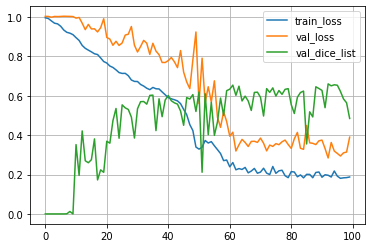

In [22]:
# Plot training loss and validation loss
plt.grid('on')
plt.plot(np.arange(NUM_EPOCH),train_loss_list,label='train_loss')
plt.plot(np.arange(NUM_EPOCH),val_loss_list, label='val_loss')
plt.plot(np.arange(NUM_EPOCH),val_dice_list, label='val_dice_list')
plt.legend()

# 6.Test

## Reload the model

In [16]:
checkpoint_path = '/scratch/yl7692/attention_gate_3D_Unet_revise_grouping/MRISegEpoch96.pth'
net = AttU_Net(4,1).to(device)
net.load_state_dict(torch.load(checkpoint_path))
net.eval()

AttU_Net(
  (Maxpool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05,

In [40]:
def eval_epoch_threshold(net, data_loader, metric, criterion,threshold):
    # set model in eval mode to avoid updating BN layer
    net = net.eval()
    
    metric_stat = []
    metric_stat_mask1 = []
    metric_stat_mask2 = []
    
    val_loss_stat = []
    val_stat_mask1 = []
    val_stat_mask2 = []
    for i, img_mask in enumerate(data_loader):
        img, mask1,mask2 = img_mask
        # send data to device
        img = img.to(device)
        mask1 = mask1.to(device)
        mask2 = mask2.to(device)
        # feed data to the model. No need to compute grad.
        with torch.no_grad():
            pred = net(img)
            val_loss_mask1 = criterion(pred, mask1)
            val_loss_mask2 = criterion(pred, mask2)
            val_loss = (val_loss_mask1 + val_loss_mask2)/2.
            
        # eval the results using DICE function as the metric
        # Convert probability to prediction mask
        pred = pred>threshold
        
        err_mask1 = dice_coeff(pred, mask1)
        err_mask2 = dice_coeff(pred, mask2)
        err = (err_mask1 + err_mask2)/2.
        
        metric_stat_mask1 += [err_mask1.item()]*img.shape[0]
        metric_stat_mask2 += [err_mask2.item()]*img.shape[0]
        metric_stat += [err.item()]*img.shape[0]
        
        val_stat_mask1 += [val_loss_mask1.item()]*img.shape[0]
        val_stat_mask2 += [val_loss_mask2.item()]*img.shape[0]
        val_loss_stat += [val_loss.item()]*img.shape[0]
        
    print ("Dice: {:.3f}  Dice_mask1: {:.3f}  Dice_mask2: {:.3f}  Val Loss: {:.3f}  Val Loss_mask1: {:.3f}  Val Loss_mask2: {:.3f} threshold:{:.3f}".
           format(np.mean(metric_stat), np.mean(metric_stat_mask1),np.mean(metric_stat_mask2),
                  np.mean(val_loss_stat),np.mean(val_stat_mask1),np.mean(val_stat_mask2), threshold))
    
    return np.mean(val_loss_stat), np.mean(val_stat_mask1), np.mean(val_stat_mask2), np.mean(metric_stat), np.mean(metric_stat_mask1), np.mean(metric_stat_mask2)

In [42]:
for threshold in range(20):
    val_loss, val_loss_mask1, val_loss_mask2, dice, dice_mask1, dice_mask2 = eval_epoch_threshold(net, val_loader, dice_coeff, criterion,threshold*0.05)

Dice: 0.007  Dice_mask1: 0.008  Dice_mask2: 0.006  Val Loss: 0.307  Val Loss_mask1: 0.277  Val Loss_mask2: 0.338 threshold0.000
Dice: 0.253  Dice_mask1: 0.278  Dice_mask2: 0.227  Val Loss: 0.307  Val Loss_mask1: 0.277  Val Loss_mask2: 0.338 threshold0.050
Dice: 0.417  Dice_mask1: 0.453  Dice_mask2: 0.381  Val Loss: 0.307  Val Loss_mask1: 0.277  Val Loss_mask2: 0.338 threshold0.100
Dice: 0.481  Dice_mask1: 0.519  Dice_mask2: 0.443  Val Loss: 0.307  Val Loss_mask1: 0.277  Val Loss_mask2: 0.338 threshold0.150
Dice: 0.528  Dice_mask1: 0.568  Dice_mask2: 0.489  Val Loss: 0.307  Val Loss_mask1: 0.277  Val Loss_mask2: 0.338 threshold0.200
Dice: 0.566  Dice_mask1: 0.605  Dice_mask2: 0.526  Val Loss: 0.307  Val Loss_mask1: 0.277  Val Loss_mask2: 0.338 threshold0.250
Dice: 0.596  Dice_mask1: 0.634  Dice_mask2: 0.558  Val Loss: 0.307  Val Loss_mask1: 0.277  Val Loss_mask2: 0.338 threshold0.300
Dice: 0.622  Dice_mask1: 0.658  Dice_mask2: 0.585  Val Loss: 0.307  Val Loss_mask1: 0.277  Val Loss_mask

## Dispaly the output mask

In [18]:
img, mask1, mask2 = val_dataset[0]
result = net(img.unsqueeze(0).to(device)).detach()
mask_pred = result.cpu().numpy()[0,0,:,:,:]
mask_pred[mask_pred>0.575] = 1
mask_pred[mask_pred<=0.575] = 0
print(mask_pred.shape)

(181, 217, 181)


Manual Volume for mask1: 4331.0
Manual Volume for mask2: 4013.0
Segmentation Volume: 4206.0


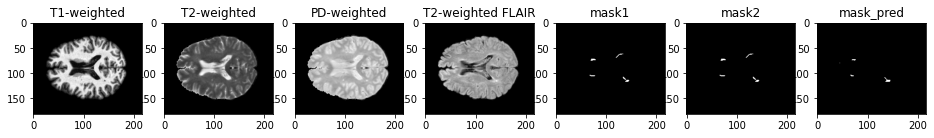

In [19]:
plt.figure(figsize = (16,32))
plt.subplot(1,7,1)
plt.imshow(img[0,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T1-weighted')
plt.subplot(1,7,2)
plt.imshow(img[1,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted')
plt.subplot(1,7,3)
plt.imshow(img[2,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('PD-weighted')
plt.subplot(1,7,4)
plt.imshow(img[3,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted FLAIR')
plt.subplot(1,7,5)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask1')
plt.subplot(1,7,6)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask2')
plt.subplot(1,7,7)
plt.imshow(mask_pred[:,:,90],'gray')
plt.title('mask_pred')

print('Manual Volume for mask1:',mask1.cpu().numpy().sum())
print('Manual Volume for mask2:',mask2.cpu().numpy().sum())
print('Segmentation Volume:',mask_pred.sum())

## Comparing with original and preprocessed

In [51]:
test_datapath = '/scratch/yl7692/testing/testdata_website'

In [52]:
class MRITestDataset(Dataset):
    def __init__(self, img_path_list, IF_TRAIN= False):
        self.mri_path_list = img_path_list
        self.IF_TRAIN = IF_TRAIN
        #self.transform=transforms.Compose([transforms.Normalize((0.5,),(0.5,))])
        self.mri_list = self.preprocess() 

    def __len__(self):
        return len(self.mri_list)

    def preprocess(self):
        mri_list = []
        for idx in tqdm(range(len(self.mri_path_list))):
            mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
            mri_t2f = (mri_t2f-mri_t2f.min())/(mri_t2f.max()-mri_t2f.min())
            
            mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
            mri_t1w = (mri_t1w-mri_t1w.min())/(mri_t1w.max()-mri_t1w.min())
            
            mri_pd = torch.Tensor(nib.load(self.mri_path_list[idx][2]).get_data())
            mri_pd = (mri_pd-mri_pd.min())/(mri_pd.max()-mri_pd.min())
            
            mri_t2w = torch.Tensor(nib.load(self.mri_path_list[idx][3]).get_data())
            mri_t2w = (mri_t2w-mri_t2w.min())/(mri_t2w.max()-mri_t2w.min())
            
            mri = torch.cat((mri_t1w.unsqueeze(0),mri_t2w.unsqueeze(0),mri_pd.unsqueeze(0),mri_t2f.unsqueeze(0)),axis=0)
        
            
            mri_list.append(mri)

        return mri_list

    def __getitem__ (self,idx):
        img = self.mri_list[idx]
        return img

In [56]:
second_testing_path_list = []
for i in range(1,15):
    if i<10:
        second_testing_path_list.append('test0' + str(i) + '/')
    else:
        second_testing_path_list.append('test' + str(i) + '/')
        

mri_test_list = []

for i in range(14):
    timepoint1_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_01_*.nii')
    timepoint2_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_02_*.nii')
    timepoint3_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_03_*.nii')
    timepoint4_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_04_*.nii')
    if (i==1 or i==9 or i==10 or i==13):
        timepoint5_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_05_*.nii')
    if i==9: 
        timepoint6_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_06_*.nii') 
        print(timepoint6_path)
    
    timepoint1_list = sorted(glob.glob(timepoint1_path))
    timepoint2_list = sorted(glob.glob(timepoint2_path))
    timepoint3_list = sorted(glob.glob(timepoint3_path))
    timepoint4_list = sorted(glob.glob(timepoint4_path))
   
    
    if (i==1 or i==9 or i==10 or i==13):
        timepoint5_list = sorted(glob.glob(timepoint5_path))
    if i==9:
        timepoint6_list = sorted(glob.glob(timepoint6_path))
    

    mri_test_list.append(timepoint1_list)
    mri_test_list.append(timepoint2_list)
    mri_test_list.append(timepoint3_list)
    mri_test_list.append(timepoint4_list)

    if (i==1 or i==9 or i==10 or i==13):
        mri_test_list.append(timepoint5_list)

    if i==9:
        mri_test_list.append(timepoint6_list)
        

print('Data Collected:', len(mri_test_list))

/scratch/yl7692/testing/testdata_website/test10/preprocessed/*_06_*.nii
Data Collected: 61


In [57]:
test_dataset = MRITestDataset(mri_test_list, IF_TRAIN= True)

  0%|          | 0/61 [00:00<?, ?it/s]<ipython-input-52-cca191b18e00>:14: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
<ipython-input-52-cca191b18e00>:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
<ipython-input-52-cca191b18e00>:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more p

In [58]:
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                         batch_size=1, 
                                         shuffle=False, 
                                         num_workers=0)

In [65]:
def pre_and_save(net, dataloader):
    net = net.eval()
    num_list = [4,5,4,4,4,4,4,4,4,6,5,4,4,5]
    cnt_num = 0;
    cnt = 0;
    for i, test_input in enumerate(dataloader):
        test_input = test_input.to(device)
        with torch.no_grad():
            pred = net(test_input[0].unsqueeze(0).to(device)).detach()
            pred[pred>0.575] = 1
            pred[pred<=0.575] = 0
            pred = pred.cpu().numpy().squeeze()
            new_image = nib.Nifti1Image(pred, np.eye(4)) 
            
        if (cnt == num_list[cnt_num]):
            cnt_num += 1
            cnt = 0;
        if i < 37:
            nib.save(new_image, '/scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/' + 'test0' + str(cnt_num+1) + '_0' + str(cnt+1)+ '_NYU.nii')
        else:
            nib.save(new_image, '/scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/' + 'test' + str(cnt_num+1) + '_0' + str(cnt+1)+ '_NYU.nii')
        cnt = cnt+1

In [66]:
num_list = [4,5,4,4,4,4,4,4,4,6,5,4,4,5]
print(sum(num_list))

61


In [67]:
pre_and_save(net, test_loader)

(181, 217, 181)


<ipython-input-78-686d48e01f45>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  testimg = nib.load('/scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/test04_04_NYU.nii').get_data()


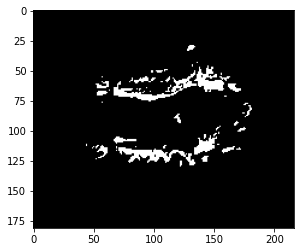

In [78]:
testimg = nib.load('/scratch/yl7692/attention_gate_3D_Unet_revise_grouping_result/test04_04_NYU.nii').get_data()
print(testimg.shape)
plt.imshow(testimg[:,:,90], cmap='gray')